# Install Libraries and Mount Drive

In [1]:
!pip install numpy==1.26.0
!pip install -q flwr[simulation] torch torchvision matplotlib opacus
!pip install --upgrade ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: ray
    Found existing installation: ray 2.31.0
    Uninstalling ray-2.31.0:
      Successfully uninstalled ray-2.31.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries and Set Global Variables

In [3]:
# -*- coding: utf-8 -*-
"""MIMIC-IV Federated Learning with Flower and PyTorch"""

# Install dependencies (Uncomment if running in Colab)
# !pip install -q flwr[simulation] torch torchvision pandas numpy scikit-learn

from collections import OrderedDict
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from opacus import PrivacyEngine

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

# Set up variables
NUM_CLIENTS = 5  # Number of federated clients
NUM_ROUNDS = 25 # Number of rounds


Training on cpu
Flower 1.17.0 / PyTorch 2.6.0+cu124


# Preprocess the Data

In [4]:
# Load datasets
import pandas as pd
from scipy import stats

# Load datasets
DEFAULT_PATH = "/content/drive/MyDrive/MA 591/Dataset/"
BATCH_SIZE = 32

df = pd.read_csv(DEFAULT_PATH + "merged_data.csv")

df.rename(columns={"Temperature (°F)": "Temperature", "hospital_expire_flag":"Hospital_Expire_Flag"}, inplace=True)

features = ['subject_id', 'ABP Diastolic', 'ABP Systolic', 'Glucose', 'Heart Rate', 'Respiratory Rate', 'Temperature', 'Hospital_Expire_Flag']
df = df[features]

# Remove outliers
for feature in features:
  if feature not in ['subject_id', 'Hospital_Expire_Flag']:
    q_low = df[feature].quantile(0.01)
    q_hi  = df[feature].quantile(0.99)
    df = df[(df[feature] < q_hi) & (df[feature] > q_low)]


df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(df)

count_total = df.shape[0]
count_0 = df[df['Hospital_Expire_Flag'] == 0].shape[0]
count_1 = df[df['Hospital_Expire_Flag'] == 1].shape[0]

print(f"~{round(100*count_0/count_total)}% of the data has Hospital_Expire_Flag = 0")
print(f"~{round(100*count_1/count_total)}% of the data has Hospital_Expire_Flag = 1")

# # We will make this distribution equal

difference = count_0 - count_1

df_majority = df[df['Hospital_Expire_Flag'] == 0]
df_minority = df[df['Hospital_Expire_Flag'] == 1]

df_majority_downsampled = df_majority.sample(n=count_1, random_state=42)

df = pd.concat([df_majority_downsampled, df_minority])

df = df.drop(df.index[:22])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced data:")

count_total = df.shape[0]
count_0 = df[df['Hospital_Expire_Flag'] == 0].shape[0]
count_1 = df[df['Hospital_Expire_Flag'] == 1].shape[0]
print(f"~{round(100*count_0/count_total)}% of the data has Hospital_Expire_Flag = 0")
print(f"~{round(100*count_1/count_total)}% of the data has Hospital_Expire_Flag = 1")

print()

print(df)

       subject_id  ABP Diastolic  ABP Systolic  Glucose  Heart Rate  \
0        10002013          61.48        110.62    98.00       94.21   
1        10002114          66.72        101.30    99.86       80.85   
2        10002155          57.40        113.40   125.64       89.75   
3        10002155          57.40        113.40   125.64       89.75   
4        10002428          59.01        110.99   109.23       96.97   
...           ...            ...           ...      ...         ...   
29787    19997448          60.90        105.42   116.86       96.89   
29788    19997752          48.44        122.72   102.33       76.33   
29789    19998770          58.76        113.47   133.50       96.35   
29790    19999287          54.54        114.69   113.00       88.57   
29791    19999442          82.81        127.47   120.12       59.45   

       Respiratory Rate  Temperature  Hospital_Expire_Flag  
0                 15.19        97.50                     0  
1                 16.75  

# Analyze the Distributions

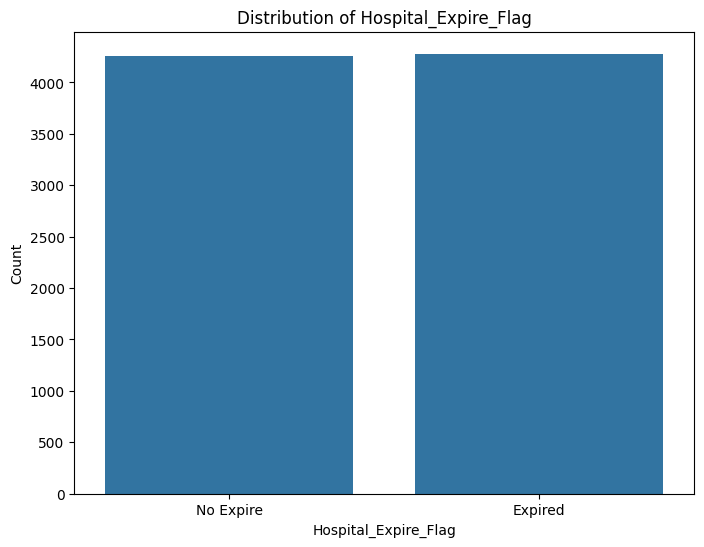

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Hospital_Expire_Flag', data=df)
plt.title('Distribution of Hospital_Expire_Flag')
plt.xlabel('Hospital_Expire_Flag')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Expire', 'Expired'])
plt.show()

count_total = len(df)
count_0 = df['Hospital_Expire_Flag'].value_counts()[0]
count_1 = df['Hospital_Expire_Flag'].value_counts()[1]



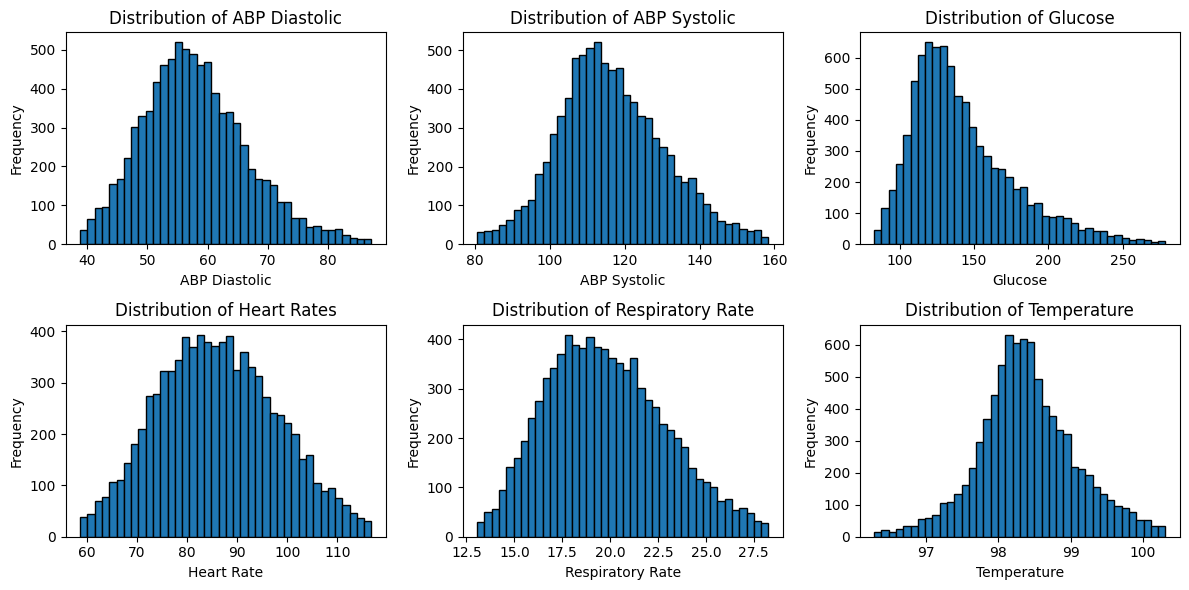

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # 2 rows, 3 columns

# List of variables and corresponding axes positions
variables = ['ABP Diastolic', 'ABP Systolic', 'Glucose', 'Heart Rate', 'Respiratory Rate', 'Temperature']
titles = ["Distribution of ABP Diastolic", "Distribution of ABP Systolic", "Distribution of Glucose",
          "Distribution of Heart Rates", "Distribution of Respiratory Rate", "Distribution of Temperature"]

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through variables and plot
for i, var in enumerate(variables):
    axes[i].hist(df[var], bins=40, edgecolor='black')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# Run Federated Learning

In [7]:
# Prepare features and target
X = df.drop(columns=["subject_id", "Hospital_Expire_Flag"])
y = df["Hospital_Expire_Flag"]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

client_data_size = len(X_tensor) // NUM_CLIENTS
datasets = random_split(TensorDataset(X_tensor, y_tensor), [client_data_size] * NUM_CLIENTS)

# Define Neural Network Model
class MortalityNN(nn.Module):
    def __init__(self, input_dim):
        super(MortalityNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

def train(net, trainloader, epochs: int):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Initialize and attach the PrivacyEngine
    privacy_engine = PrivacyEngine(
         net,
         batch_size=BATCH_SIZE,
         sample_size=len(trainloader.dataset),
         alphas=[10, 100],
         noise_multiplier=0.5,  # Adjust this value to control the privacy budget
         max_grad_norm=1.0,     # Gradient clipping norm
    )
    privacy_engine.attach(optimizer)

    net.train()
    for epoch in range(epochs):
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()
            y_pred = net(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Compute the epsilon value for your privacy budget
    epsilon = privacy_engine.get_epsilon(delta=1e-5)
    print(f"Achieved privacy guarantee: ε = {epsilon:.2f}")

    privacy_engine.detach()


# Testing function
def test(net, testloader):
    criterion = nn.BCELoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for X_batch, y_batch in testloader:
            y_pred = net(X_batch)
            loss += criterion(y_pred, y_batch).item()
            predicted = (y_pred > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return loss / len(testloader.dataset), correct / total

# Flower Client
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.trainloader, epochs=10)
        return self.get_parameters(config), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"accuracy": sum(accuracies) / sum(examples)}

# Create the federated clients
def client_fn(context: Context) -> Client:
    partition_id = context.node_config["partition-id"]
    model = MortalityNN(X.shape[1])
    train_loader = DataLoader(datasets[partition_id], batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(datasets[partition_id], batch_size=BATCH_SIZE)
    return FlowerClient(model, train_loader, valloader).to_client()

# Create ClientApp
client_app = ClientApp(client_fn=client_fn)

class DummyIns:
    def __init__(self, config):
        self.config = config

class LoggingFedAvg(FedAvg):
    def __init__(self, *args, **kwargs):
        super(LoggingFedAvg, self).__init__(*args, **kwargs)
        self.client_weights_history = []
        self.accuracies = []  # Store accuracies

    def aggregate_fit(self, rnd: int, results, failures):
        round_client_weights = []
        for fit_res in results:
            param_obj = fit_res[0]
            dummy_ins = DummyIns(config={})
            param_obj = param_obj.get_parameters(timeout=10, group_id="", ins=dummy_ins)
            if hasattr(param_obj, "parameters"):
                param_obj = param_obj.parameters
            round_client_weights.append(param_obj)

        self.client_weights_history.append({
            "round": rnd,
            "client_weights": round_client_weights,
        })

        return super().aggregate_fit(rnd, results, failures)

    def aggregate_evaluate(self, rnd: int, results, failures):
        if results:
            round_accuracy = results
            self.accuracies.append(round_accuracy)  # Store accuracy for plotting
            # print(f"Round {rnd} Accuracy: {round_accuracy:.4f}")  # Log accuracy

        return super().aggregate_evaluate(rnd, results, failures)




# Define server strategy
# All clients participate
strategy = LoggingFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average
)

# Define ServerApp
def server_fn(context: Context) -> ServerAppComponents:
    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=NUM_ROUNDS))

server_app = ServerApp(server_fn=server_fn)

# Configure resources for clients
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

# Run the federated simulation
result = run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)


Streaming output truncated to the last 5000 lines.
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe_call_fit
    return client.fit(fit_ins)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/numpy_client.py", line 227, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-7-a092052f8481>", line 93, in fit
  File "<ipython-input-7-a092052f8481>", line 36, in train
TypeError: PrivacyEngine.__init__

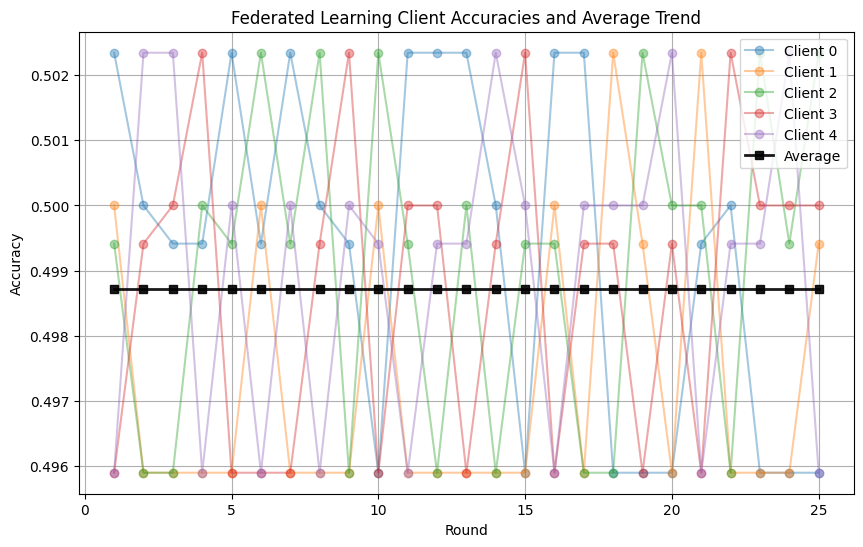

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

assert(len(strategy.accuracies) == NUM_ROUNDS) # Sanity Check

accuracies = {}

for client in range(NUM_CLIENTS):
  accuracies[f"Client {client}"] = []

for round in range(NUM_ROUNDS):
  for client in range(NUM_CLIENTS):
    eval_res_obj = strategy.accuracies[round][client][1]
    accuracy = eval_res_obj.metrics['accuracy']
    accuracies[f"Client {client}"].append(accuracy)


assert(len(next(iter(accuracies.values()))) == NUM_ROUNDS) # Sanity Check

# Calculate the average accuracy for each client
avg_accuracies = [np.mean([accuracies[client][i] for client in accuracies]) for i in range(NUM_ROUNDS)]

# Plot each client's accuracy
plt.figure(figsize=(10, 6))
for client, acc_values in accuracies.items():
    plt.plot(range(1, NUM_ROUNDS + 1), acc_values, marker='o', linestyle='-', label=client, alpha=0.4)

# Plot the average accuracy trend
plt.plot(range(1, NUM_ROUNDS + 1), avg_accuracies, marker='s', linestyle='-', color='black', linewidth=2, label="Average", alpha=0.9)

# Labels and Title
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Federated Learning Client Accuracies and Average Trend")
plt.legend()
plt.grid(True)

# Show plot
plt.show()